## House Price Prediction  
##### Kaggle competition https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.  

In first let's import libraries we need

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold

Now we can see on train data we have

In [66]:
train_data = pd.read_csv(r'D:\Python\Kaggle\House Prices\train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
print(train_data.shape)

(1460, 81)


Make the first prediction

In [68]:
features = ['GrLivArea'] # Above grade (ground) living area square
target = "SalePrice"
kf = KFold(n_splits=10, shuffle=True, random_state = 5)
rmse_values = []
for train_index, test_index, in kf.split(train_data):
    train = train_data.iloc[train_index]
    test = train_data.iloc[test_index]
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)
        
    avg_rmse = np.mean(rmse_values)

print(avg_rmse) 

55910.3335665


RMSE mean, that our model in average makes a mistake on 55910 $  
Let's try improve quality of prediction  

1. Feature Engineering - cleaning our data: exclude missing value, categirical value.  
2. Feature Selection - choose most apropriate features  
3. Make prediction with choosed features

# Step 1. Feature Engineering  

**1. Work with all columns**

- Drop columns wthich conisist more than 5% of missing values.

In [69]:
data_isnull = train_data.isnull().sum()
data_missing = data_isnull[(data_isnull > 0.05*len(train_data))]
data_missing

LotFrontage      259
Alley           1369
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [70]:
data_filtred = train_data.drop(data_missing.index, axis = 1)
data_filtred.shape

(1460, 70)

** 2. Work with numerical columns**

- For numerical columns contain less than 5% missing values, fill in the missing values using the most popular value for that column.

In [71]:
data_numerical = data_filtred.select_dtypes(include = ['float', 'integer'])
data_num_missing = data_numerical.isnull().sum()
col_for_fill = data_num_missing[(data_num_missing >0)]
col_for_fill

MasVnrArea    8
dtype: int64

Impute missing values with the mode in a data_numerical by
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mode.html

In [72]:
data_filled = data_filtred[col_for_fill.index].fillna(data_filtred[col_for_fill.index].mode().iloc[0])

Verify that every column has 0 missing values

In [73]:
data_filled.isnull().sum()

MasVnrArea    0
dtype: int64

In [74]:
data_filtred[col_for_fill.index] = data_filled
data_filtred.shape

(1460, 70)

We can see that every thing is ok, so we can continue with answer the quision - What new features can we create, that better capture the information in some of the features? Information about the different columns is in the **data_description.txt**.  

It is usefull to know how old is home and how much time has passed since remodeling, instead just year when it was build or remodeling

In [75]:
years_until_remod = train_data['YrSold'] - train_data['YearRemodAdd']
year_before_sold = train_data['YrSold'] - train_data['YearBuilt']

If the difference is less than zero, so there is some mistake

In [76]:
year_before_sold[year_before_sold < 0]

Series([], dtype: int64)

In [77]:
years_until_remod[years_until_remod < 0]

523   -1
dtype: int64

We must take into account that in row 523 the year is incorrectly specified and drop this row

In [78]:
data_filtred['YearSinceRemod'] = years_until_remod
data_filtred['YearBeforeSale'] = year_before_sold

data_filtred = data_filtred.drop(['YrSold', 'YearRemodAdd','YearBuilt' ], axis = 1 )
data_filtred = data_filtred.drop([523], axis = 0)
data_filtred.shape

(1459, 69)

We have to find columns, which aren't useful for machine learning
- ID - is just a Observation number
- MoSold - month, when house was sold

In [79]:
data_filtred = data_filtred.drop(['Id', 'MoSold'], axis = 1)

**3. Work with text columns**   
There is some columns which leak data about the final sale  
 - SaleCondition - condition of sale  
 - SaleType - type of sale  
 
We don't need to use its in our model

In [80]:
data_filtred = data_filtred.drop(['SaleCondition', 'SaleType'], axis = 1)

Futher work with text columns

In [81]:
data_object = data_filtred.select_dtypes(include = ['object'])

Exclude all text columns which consist missing values

In [82]:
data_object_null = data_object.isnull().sum()
data_object_null = data_object_null[data_object_null > 0]
data_object_null

MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
dtype: int64

In [83]:
data_filtred = data_filtred.drop(data_object_null.index, axis = 1)
data_filtred.shape

(1459, 58)

In [84]:
data_object = data_object.drop(data_object_null.index, axis = 1)

If a categorical column has hundreds of unique values (or categories), will be confuse made a lot of new columns with dummy coding. 
From the other hand if categorical columns have only a few unique values but more than 95% of the values in the column belong to a specific category, this would be similar to a low variance numerical feature (no variability in the data for the model to capture).

For now let's see how much unique values every column consist

In [85]:
columns = data_object.columns

unique_values_count = {}
for col in columns:
    unique_value = data_object[col].value_counts()
    unique_values_count[col] = unique_value
    
unique_values_count

{'BldgType': 1Fam      1219
 TwnhsE     114
 Duplex      52
 Twnhs       43
 2fmCon      31
 Name: BldgType, dtype: int64, 'CentralAir': Y    1364
 N      95
 Name: CentralAir, dtype: int64, 'Condition1': Norm      1260
 Feedr       81
 Artery      48
 RRAn        26
 PosN        18
 RRAe        11
 PosA         8
 RRNn         5
 RRNe         2
 Name: Condition1, dtype: int64, 'Condition2': Norm      1445
 Feedr        6
 RRNn         2
 Artery       2
 RRAn         1
 PosN         1
 PosA         1
 RRAe         1
 Name: Condition2, dtype: int64, 'ExterCond': TA    1281
 Gd     146
 Fa      28
 Ex       3
 Po       1
 Name: ExterCond, dtype: int64, 'ExterQual': TA    906
 Gd    488
 Ex     51
 Fa     14
 Name: ExterQual, dtype: int64, 'Exterior1st': VinylSd    515
 HdBoard    222
 MetalSd    220
 Wd Sdng    206
 Plywood    108
 CemntBd     60
 BrkFace     50
 WdShing     26
 Stucco      25
 AsbShng     20
 Stone        2
 BrkComm      2
 AsphShn      1
 ImStucc      1
 CBlock       1

Cut off categorical columns which have more than 95% of the values in the column related to a specific category

In [86]:
columns_more_95 = ['Condition2','Heating','LandSlope', 'RoofMatl', 'Street', 'Utilities']
data_object = data_object.drop(columns_more_95  , axis = 1)
data_filtred = data_filtred.drop(columns_more_95  , axis = 1)

Find columns which have less than 8 unique value

In [45]:
col_unique_new = data_object.columns.tolist()
col_unique_new

short_col_unique = []
for col in col_unique_new:
    if len(data_object[col].value_counts()) < 8:
        short_col_unique.append(col)
        
print(len(short_col_unique))
print(len(col_unique_new))

14
19


In [87]:
data_object_long = data_object.drop(short_col_unique, axis = 1).columns
data_filtred = data_filtred.drop(data_object_long, axis = 1)

In [88]:
data_filtred.shape

(1459, 47)

We need names of columns we will coding - short_col_unique, but back to this later

# Feature Selection

Find correlation between numerical features we have and target value **Sale Price**

In [94]:
data_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 47 columns):
MSSubClass        1459 non-null int64
MSZoning          1459 non-null object
LotArea           1459 non-null int64
LotShape          1459 non-null object
LandContour       1459 non-null object
LotConfig         1459 non-null object
BldgType          1459 non-null object
OverallQual       1459 non-null int64
OverallCond       1459 non-null int64
RoofStyle         1459 non-null object
MasVnrArea        1459 non-null float64
ExterQual         1459 non-null object
ExterCond         1459 non-null object
Foundation        1459 non-null object
BsmtFinSF1        1459 non-null int64
BsmtFinSF2        1459 non-null int64
BsmtUnfSF         1459 non-null int64
TotalBsmtSF       1459 non-null int64
HeatingQC         1459 non-null object
CentralAir        1459 non-null object
1stFlrSF          1459 non-null int64
2ndFlrSF          1459 non-null int64
LowQualFinSF      1459 non-null int64
GrLivA

In [97]:
num_data_filtred = data_filtred.select_dtypes(include=['int64', 'float64'])
data_corr = num_data_filtred.corr()

In [98]:
abs_corr_coeffs = data_corr['SalePrice'].abs().sort_values()
print(abs_corr_coeffs)

BsmtFinSF2        0.011369
BsmtHalfBath      0.016837
MiscVal           0.021187
LowQualFinSF      0.025602
3SsnPorch         0.044588
OverallCond       0.077846
MSSubClass        0.084287
PoolArea          0.092406
ScreenPorch       0.111458
EnclosedPorch     0.128572
KitchenAbvGr      0.135903
BedroomAbvGr      0.168209
BsmtUnfSF         0.214492
BsmtFullBath      0.227181
LotArea           0.264543
HalfBath          0.284214
OpenPorchSF       0.318911
2ndFlrSF          0.320062
WoodDeckSF        0.324475
BsmtFinSF1        0.388407
Fireplaces        0.466967
MasVnrArea        0.474663
YearSinceRemod    0.509276
YearBeforeSale    0.523573
TotRmsAbvGrd      0.535030
FullBath          0.561887
1stFlrSF          0.611181
TotalBsmtSF       0.618211
GarageArea        0.624160
GarageCars        0.640954
GrLivArea         0.717382
OverallQual       0.793055
SalePrice         1.000000
Name: SalePrice, dtype: float64


Keep columns with a correlation coefficient of larger than 0.45 (arbitrary)

In [99]:
weak_corr = abs_corr_coeffs[abs_corr_coeffs < 0.45]
data_strong_corr = data_filtred.drop(weak_corr.index, axis = 1)

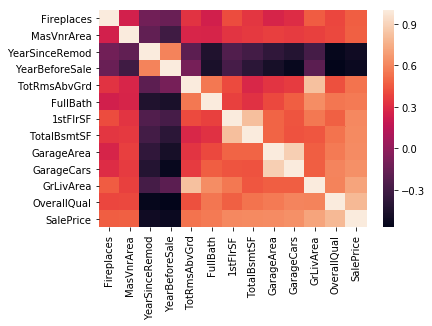

In [100]:
strong_corr = abs_corr_coeffs[abs_corr_coeffs > 0.45]
num_strong_corr = num_data_filtred[strong_corr.index]
strong_corr = num_strong_corr.corr()
sns.heatmap(strong_corr)

We can see that this pairs have strong correlation between each other:  
• Gr Liv Area and TotRms AbvGrd  
• Garage Area and Garage Cars

**Garage Cars (Discrete)**: Size of garage in car capacity  
**Garage Area (Continuous)**: Size of garage in square feet  
**Gr Liv Area (Continuous)**: Above grade (ground) living area square feet   
**TotRmsAbvGrd (Discrete)**: Total rooms above grade (does not include bathrooms)

The columns mean approximly the same, so information dublicate, so let's drop columns Garage Cars and TotRmsAbvGrd

In [103]:
data_strong_corr = data_strong_corr.drop(['Garage Cars', 'TotRms AbvGrd'], axis = 1)
data_strong_corr.shape

(1459, 27)

Now it's time to back to dummy codding of categorical data

In [104]:
for col in short_col_unique:
    dummy_col = pd.get_dummies(data_strong_corr[col])
    data_strong_corr = pd.concat([data_strong_corr, dummy_col], axis = 1)
    data_strong_corr = data_strong_corr.drop(col, axis = 1)
    
data_strong_corr.shape

(1459, 78)

# Make prediction

In [107]:
data_strong_corr.head()

,OverallQual,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,...,Maj1,Maj2,Min1,Min2,Mod,Sev,Typ,N,P,Y
0,7,196.0,856,856,1710,2,8,0,2,548,...,0,0,0,0,0,0,1,0,0,1
1,6,0.0,1262,1262,1262,2,6,1,2,460,...,0,0,0,0,0,0,1,0,0,1
2,7,162.0,920,920,1786,2,6,1,2,608,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,756,961,1717,1,7,1,3,642,...,0,0,0,0,0,0,1,0,0,1
4,8,350.0,1145,1145,2198,2,9,1,3,836,...,0,0,0,0,0,0,1,0,0,1


In [115]:
features_data = data_strong_corr.drop(['SalePrice'], axis= 1)
features_data.columns

Index(['OverallQual', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
       'YearSinceRemod', 'YearBeforeSale', 'C (all)', 'FV', 'RH', 'RL', 'RM',
       'IR1', 'IR2', 'IR3', 'Reg', 'Bnk', 'HLS', 'Low', 'Lvl', 'Corner',
       'CulDSac', 'FR2', 'FR3', 'Inside', '1Fam', '2fmCon', 'Duplex', 'Twnhs',
       'TwnhsE', 'Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed', 'Ex',
       'Fa', 'Gd', 'TA', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'BrkTil', 'CBlock',
       'PConc', 'Slab', 'Stone', 'Wood', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'N',
       'Y', 'Ex', 'Fa', 'Gd', 'TA', 'Maj1', 'Maj2', 'Min1', 'Min2', 'Mod',
       'Sev', 'Typ', 'N', 'P', 'Y'],
      dtype='object')

In [116]:
features = features_data.columns
target = "SalePrice"
kf = KFold(n_splits=10, shuffle=True, random_state = 5)
rmse_values = []
for train_index, test_index, in kf.split(data_strong_corr):
    train = data_strong_corr.iloc[train_index]
    test = data_strong_corr.iloc[test_index]
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)
        
    avg_rmse = np.mean(rmse_values)

print(avg_rmse) 

33887.5237604


We can see that model became much better

# Work with test data

In [118]:
test_data = pd.read_csv(r'D:\Python\Kaggle\House Prices\test.csv')
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Make dummy coding of test data columns

In [119]:
for col in short_col_unique:
    dummy_col = pd.get_dummies(test_data[col])
    test_data = pd.concat([test_data, dummy_col], axis = 1)
    test_data = test_data.drop(col, axis = 1)
    
test_data.shape

(1459, 131)

Add columns with age of house and amount of years since remodeling

In [121]:
years_until_remod_test = test_data['YrSold'] - test_data['YearRemodAdd']
year_before_sold_test = test_data['YrSold'] - test_data['YearBuilt']

In [122]:
test_data['YearSinceRemod'] = years_until_remod_test
test_data['YearBeforeSale'] = year_before_sold_test

test_data = test_data.drop(['YrSold', 'YearRemodAdd','YearBuilt' ], axis = 1 )

test_data.shape

(1459, 130)

Exclude columns with missing values

In [128]:
feature_test_data = test_data[features]
feature_test_data_isnull = feature_test_data.isnull().sum()
feature_test_data_isnull = feature_test_data_isnull[feature_test_data_isnull > 0 ]
feature_test_data_isnull

MasVnrArea     15
TotalBsmtSF     1
GarageCars      1
GarageArea      1
dtype: int64

In [144]:
feature_test_data = feature_test_data.drop(feature_test_data_isnull.index, axis = 1)
feature = feature_test_data.columns.tolist()

Make a prediction on test data

In [136]:
lr = LinearRegression()
lr.fit(data_strong_corr[feature], data_strong_corr["SalePrice"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [137]:
predict_price = lr.predict(test_data[feature])
predict_price

array([  99919.63711519,  160922.17111798,  178610.7334598 , ...,
        145826.65960438,  130159.34128358,  219720.53641203])

Write the obtained prediction into a csv-file

In [142]:
df  = pd.DataFrame(predict_price)
df.index = test_data['Id']
df.index.name = 'Id'
df.columns = ['SalePrice']
df.head(5)

,SalePrice
Id,
1461,99919.637115
1462,160922.171118
1463,178610.733460
1464,192716.911580
1465,212302.554440


In [143]:
df.to_csv(r'D:\Python\Kaggle\House Prices\submission.csv', sep=',')

Test on Kaggle shows that obtained prediction have Root mean squared Logarithmic Error **0.23061** while  Sample Submission Benchmark **0.40**. And we are on 4453 place from 5000, not perfect but not bad for first entry.